In [1]:
import torch
import random
import numpy as np
from collections import deque
from game import SnakeGameAI, Direction, Point
from helper import plot
import pygame
import os

import math, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


game = SnakeGameAI()

move = [1,0,0] #list idx [0,1,2]
reward, game_over, score, array3D = game.play_step(move) # 0, 1 or 2


# RUN THIS IF YOU WANT TO UNDERSTAND ONLY
game = SnakeGameAI()
move = [0,0,0]
while True:
  
    reward, game_over, score,array3D = game.play_step(move)

    time.sleep(1)
    if game_over == True:
        break

print('Final Score', score)
pygame.display.quit() 
pygame.quit()
    

array3D
print(array3D.shape)

v = array3D.transpose((1,0,2))
print(v.shape)

plt.imshow(v)

# RUN THIS ONLY IF YOU WANT TO CLOSE THE PYGAME WINDOW
pygame.display.quit() 
pygame.quit()



if __name__ == '__main__':
    train()

In [2]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [3]:
def action_array(action):
    if (action < 3):
        move = np.zeros(3).astype(np.int)
        move[action] = 1
        #move = move.tolist()
        return move.tolist()
    else:
        print("exceed number of actions\n")
        return

In [4]:
def save(model, file_name='Beta1.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(model.state_dict(), file_name)

In [5]:
class CnnDQN(nn.Module):
    def __init__(self, channels_in, num_actions):
        super(CnnDQN, self).__init__()
        
        self.channels_in = channels_in
        self.num_actions = num_actions
        self.feature_size = 256
        
        self.features = nn.Sequential(
            nn.Conv2d(channels_in, 32, kernel_size=7, stride=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=3),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride = 3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        
       
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    

In [6]:
def cropImage(state, snake_head):
    dim = 45
    x = snake_head[0]
    y = snake_head[1]
    x_arr = np.array([x-dim, x+dim])
    y_arr = np.array([y-dim, y+dim])
    x_lim = np.array([0, 180])
    y_lim = np.array([0, 120])

    dif_x = x_arr - x_lim
    dif_y = y_arr - y_lim

    if(dif_x[0] < 1):
        x_arr -= dif_x[0]
    if(dif_x[1] > -1):
        x_arr -= (dif_x[1]+1)
    if(dif_y[0] < 1):
        y_arr -= dif_y[0]
    if(dif_y[1] > -1):
        y_arr -= (dif_y[1]+1)
    
    x_arr = x_arr.astype(int)
    y_arr = y_arr.astype(int)
    
    state = state[:,y_arr[0]:y_arr[1]+1,x_arr[0]:x_arr[1]+1]
    
    return state

In [7]:
def Loss(criterion, batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(np.float32(state))
    next_state = torch.FloatTensor(np.float32(next_state))
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)

    q_values      = model(state.to(device))
    next_q_values = model(next_state.to(device))

    q_value          = q_values.gather(1, action.unsqueeze(1).to(device)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward.to(device) + gamma * next_q_value * (1 - done.to(device))

    #loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    loss = criterion(q_value, expected_q_value)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

def act(state, epsilon):
        if random.random() > epsilon:
            #state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            n = random.randrange(self.num_actions)
            action = random.randrange(env.action_space.n)
        return action

In [8]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

In [9]:
channels_input = 3
num_actions = 3
model = CnnDQN(channels_input, num_actions).to(device) # (180, 120, 3) , (6)

lr = 5e-5
    
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

replay_initial = 500
replay_buffer = ReplayBuffer(6000)

# Frame:
start = 1
total_frames = 50000
batch_size = 32
gamma = 0.99


# start:
game = SnakeGameAI()

In [10]:
epsilon_start = 0.6
epsilon_final = 0.0005
epsilon_decay = 50000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)


plt.plot([epsilon_by_frame(i) for i in range(1000000)])

<Figure size 432x288 with 0 Axes>

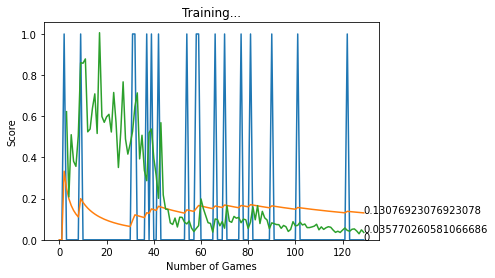

In [ ]:
plot_scores = []
plot_mean_scores = []
losses = []
loss_episode = []

total_score = 0
episode_reward = 0
out = 0
episode = 0
record = 0

#game = SnakeGameAI()
move = np.zeros(3).astype(np.int)
move = move.tolist()
_, _, _, array3D = game.play_step(move) # No.0
state = torch.tensor(array3D.transpose((2,1,0)))# Getting image in 4D Tensor
state = cropImage(state, game.head)
for curr_frame in range(start, total_frames):
    # later all this will be move into train_epoch function
    model.train()    # Start training
    
    epsilon = epsilon_by_frame(curr_frame) # No. 1
    if random.random() > epsilon:
        state = state.float()
        x = state.unsqueeze(0)
        q_value = model(x.to(device))
        action  = q_value.max(1)[1].data[0]
        #state = state.squeeze(0)
    else:
        action = random.randrange(num_actions)

    move = action_array(action)
    
    reward, game_over, score, array3D = game.play_step(move) # No.2
    next_state = torch.tensor(array3D.transpose((2,1,0))) # Getting image in 4D Tensor
    next_state = cropImage(next_state, game.head)
    replay_buffer.push(state, action, reward, next_state, game_over) # No.3
    
    state = next_state
    episode_reward += reward
    
    # Continue .... if game_over:.....
    if game_over:
        game.reset()
        episode += 1
        #train_long_memory()

        if score > record:
            record = score
            save(model)

        print('Game', episode, 'Score', score, 'Record:', record)

        plot_scores.append(score)
        total_score += score
        
        mean_score = total_score / episode
        plot_mean_scores.append(mean_score)
        
        loss_episode.append(np.mean(losses))
        losses = []
        plot(plot_scores, plot_mean_scores, loss_episode)
    
    if len(replay_buffer) > replay_initial:
        loss = Loss(criterion, batch_size)
        losses.append(loss.item())
        
    
    # hold while waiting your command:
    #out = input()
    #if (int(out) == 1):
    #    break
        
game.reset()
print('Final Score', score)
pygame.display.quit() 
pygame.quit()



In [27]:
reward, game_over, score, array3D = game.play_step(move) # No.2
next_state = torch.tensor(array3D.transpose((2,1,0))) # Getting image in 4D Tensor
next_state = cropImage(next_state, game.head)
print(next_state.shape)

error: Library not initialized

In [12]:
#print('Final Score', score)
pygame.display.quit() 
pygame.quit()

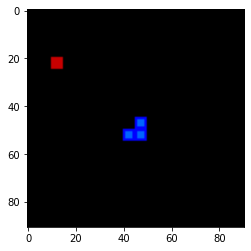

In [13]:
img = state.cpu().detach().numpy()
img = img.transpose((1,2,0))
plt.imshow(img/255)

In [ ]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset() # No.0
# No.0 - play 1st frame
# No.1 - get action from CNN
# No.2 insert action into the game - get all things -> next state
# No.3 push into buffer
# No.4 current is next state

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx) 
    action = model.act(state, epsilon) # No.1 - state & epsilon(random) to get action (random or learnt)
    
    next_state, reward, done, _ = env.step(action) # No.2
    replay_buffer.push(state, action, reward, next_state, done) # No.3
    
    state = next_state # No.4
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
          
        

    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)